In [ ]:
#   https://www.youtube.com/watch?v=CbTU92pbDKw

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from copy import deepcopy
df = pd.read_csv('MSFT.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060524,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062686,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063767,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062145,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061065,47894400
...,...,...,...,...,...,...,...
9405,2023-07-10,334.600006,335.230011,327.589996,331.829987,331.829987,32791400
9406,2023-07-11,331.059998,332.859985,327.000000,332.470001,332.470001,26698200
9407,2023-07-12,336.600006,341.649994,335.670013,337.200012,337.200012,29995300
9408,2023-07-13,339.559998,343.739990,339.019989,342.660004,342.660004,20567200


In [2]:
df = df[['Date', 'Close']]

df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9405,2023-07-10,331.829987
9406,2023-07-11,332.470001
9407,2023-07-12,337.200012
9408,2023-07-13,342.660004


In [3]:
df['Date']

0       1986-03-13
1       1986-03-14
2       1986-03-17
3       1986-03-18
4       1986-03-19
           ...    
9405    2023-07-10
9406    2023-07-11
9407    2023-07-12
9408    2023-07-13
9409    2023-07-14
Name: Date, Length: 9410, dtype: object

In [4]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [5]:
df['Date'] = df['Date'].apply(str_to_datetime) #we r not calling the function we r passing the function istself
df['Date']

C:\Users\sunil\AppData\Local\Temp\ipykernel_25472\2565755782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9405   2023-07-10
9406   2023-07-11
9407   2023-07-12
9408   2023-07-13
9409   2023-07-14
Name: Date, Length: 9410, dtype: datetime64[ns]

In [6]:
df.index = df.pop('Date') # making the dat col as index
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2023-07-10,331.829987
2023-07-11,332.470001
2023-07-12,337.200012


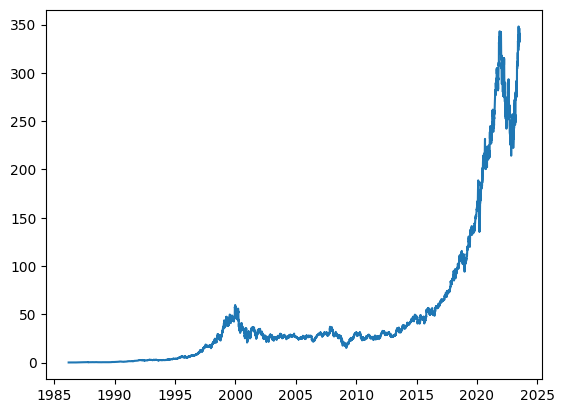

In [7]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [8]:

# converting into supervised learning model coz LSTM model use
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [9]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

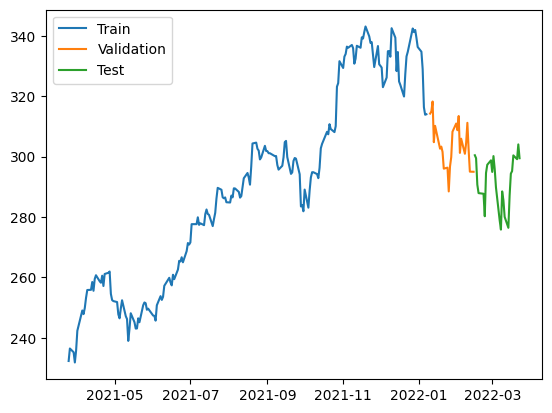

In [10]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [11]:

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 3s 113ms/step - loss: 84454.4453 - mean_absolute_error: 288.8681 - val_loss: 92139.8203 - val_mean_absolute_error: 303.4582
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 84209.3828 - mean_absolute_error: 288.4439 - val_loss: 91850.0625 - val_mean_absolute_error: 302.9803
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 83896.4297 - mean_absolute_error: 287.8983 - val_loss: 91436.2812 - val_mean_absolute_error: 302.2967
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 83437.2812 - mean_absolute_error: 287.1004 - val_loss: 90862.1328 - val_mean_absolute_error: 301.3456
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 82850.5078 - mean_absolute_error: 286.0799 - val_loss: 90144.8594 - val_mean_absolute_error: 300.1531
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 82097.5703 - mean_absolute_error: 284.7575 - val_loss: 89238.

7/7 [==============================] - 0s 3ms/step


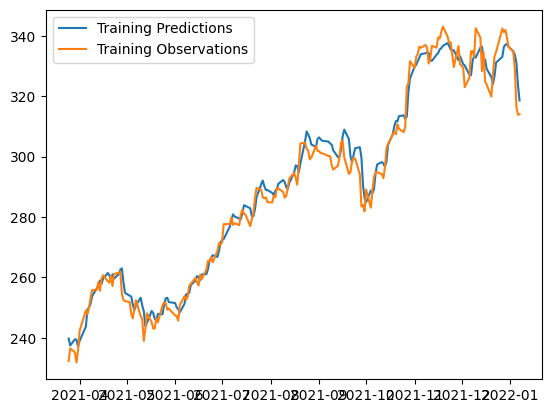

In [12]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 24ms/step


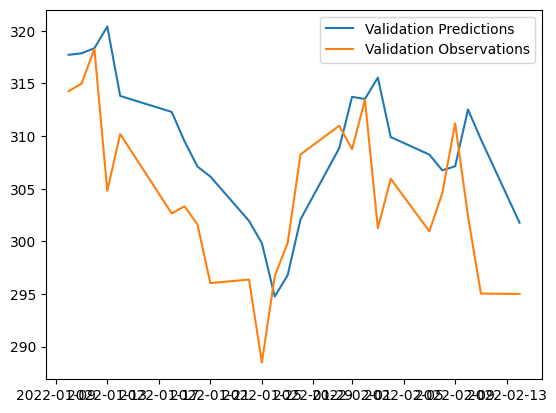

In [13]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 25ms/step


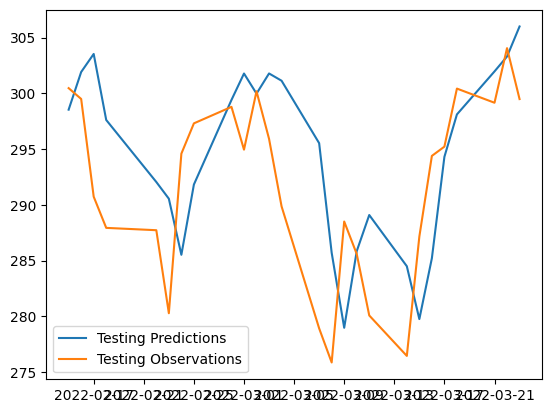

In [14]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

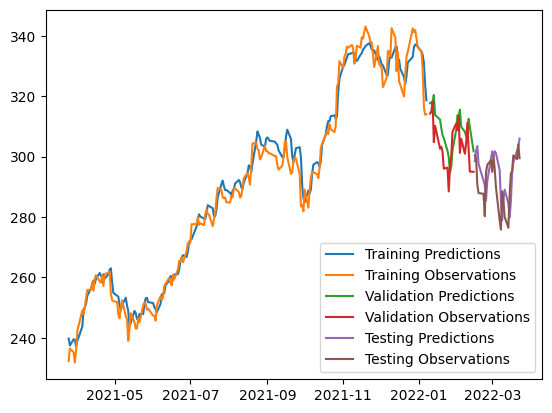

In [15]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [16]:


recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 26ms/step


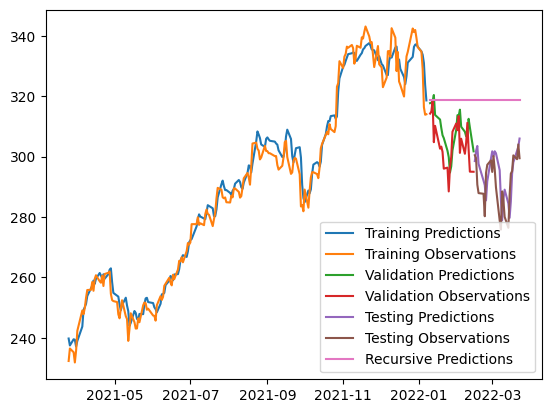

In [17]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])